In [1]:
import pandas as pd

from Throw import throw
from Kalmanfilter import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [8]:
def do_a_run(x=None, y=None, angle=None, velocity=None, dt=None, dropout=None, error_range_x=None, error_range_y=None, plot=None, title=None, values=None, gravity=9.81, Q_value=0.01, R_value=0.01, m_init = np.zeros(4)):
    """
    convenience function to do an experiment run with the kalman filter
    :param x: the horizontal position in meters the ball is launched off
    :param y: the vertical position in meters the ball is launched off
    :param velocity: velocity of the ball throw
    :param angle: in which angle the ball is thrown
    :param dt: timesteps between each measurement/ computation
    :param dropout: a tuple with two entries: The begin of the dropout and the end. begin and end included
    :param error_range_x: for the x values, a tuple consisting of two values the mean and the scale of the normal distribution to choose a random error value of
    :param error_range_y: for the y values, a tuple consisting of two values the mean and the scale of the normal distribution to choose a random error value of
    :param gravity: gravitiy in m/s, defaults to 9.81. Dont change it unless you move to the moon
    :param plot: the matplotlib axis object to plot this run on
    :param title: the title for the plot
    :param values: true values, measurement, alighned true values to use for the run
    :param Q_value: the factor to multiply the Q matrix with, Q matrix is a 4x4 matrix filled with ones
    :param R_value: the factor to multiply the R matrix with, R matrix is a 2x2 matrix filled with ones
    :param m_init: the initial value for the state variable, defaults to an array of zeros of size 4
    :return: the error between the true values and the estimates of the kalman filter
    """
    # initial parameters for the kalman filter
    # state transition model parameters
    A = np.asarray([[1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1, 0 ],
                    [0, 0, 0, 1 ]])
    # control input model parameters
    B = np.asarray([[0, 0,           0],
                    [0, 0.5*(dt**2), 0],
                    [0, 0,           0],
                    [0, dt,          0]])
    # observation model parameters
    C = np.asarray([[1, 0, 0, 0],
                    [0, 1, 0, 0]])

    Q = np.ones((4,4)) * Q_value #Estimate/process error covariance
    R = np.ones((2, 2)) * R_value #Measurement error.
    a = np.asarray([0, -gravity, 0])# the control vector/ the actions (just gravity doing its job)

    m = m_init # initial mean vector/ state
    s = np.identity(4) #

    # use given values for the throw or do a new calculation
    if values:
        true_values, measurements, aligned_true_values = values
    else:
        # determine the trajectories for the experiments
        true_values, measurements, aligned_true_values = throw(launch_pos_x=x,
                                          launch_pos_y=y,
                                          launch_angle=angle,
                                          launch_speed=velocity,
                                          dt=dt,
                                          error_range_x=error_range_x,
                                          error_range_y=error_range_y,
                                          dropout=dropout,
                                          gravity=gravity
                                          )

    # estimate with kalman filter
    kalman = KalmanFilter(A, B, C, Q, R, a, m, s)
    estimates = []
    for measurement in measurements:
        estimates.append(kalman.estimate(measurement))
    estimates = np.asarray(estimates)

    #compute mean absolute error
    error = mean_absolute_error(aligned_true_values, estimates)

    # prepare plot
    plot.set_title(title +  " Error: " + str(error))
    plot.plot(true_values[:,0], true_values[:,1], 'r--', label='True Value')
    plot.scatter(measurements[:,0], measurements[:,1], label='Measurement')
    plot.plot(estimates[:,0], estimates[:,1], "g--", label='Estimates')

    return error


## Comparing different timesteps(dt), error ranges, Q matrices and R matrices

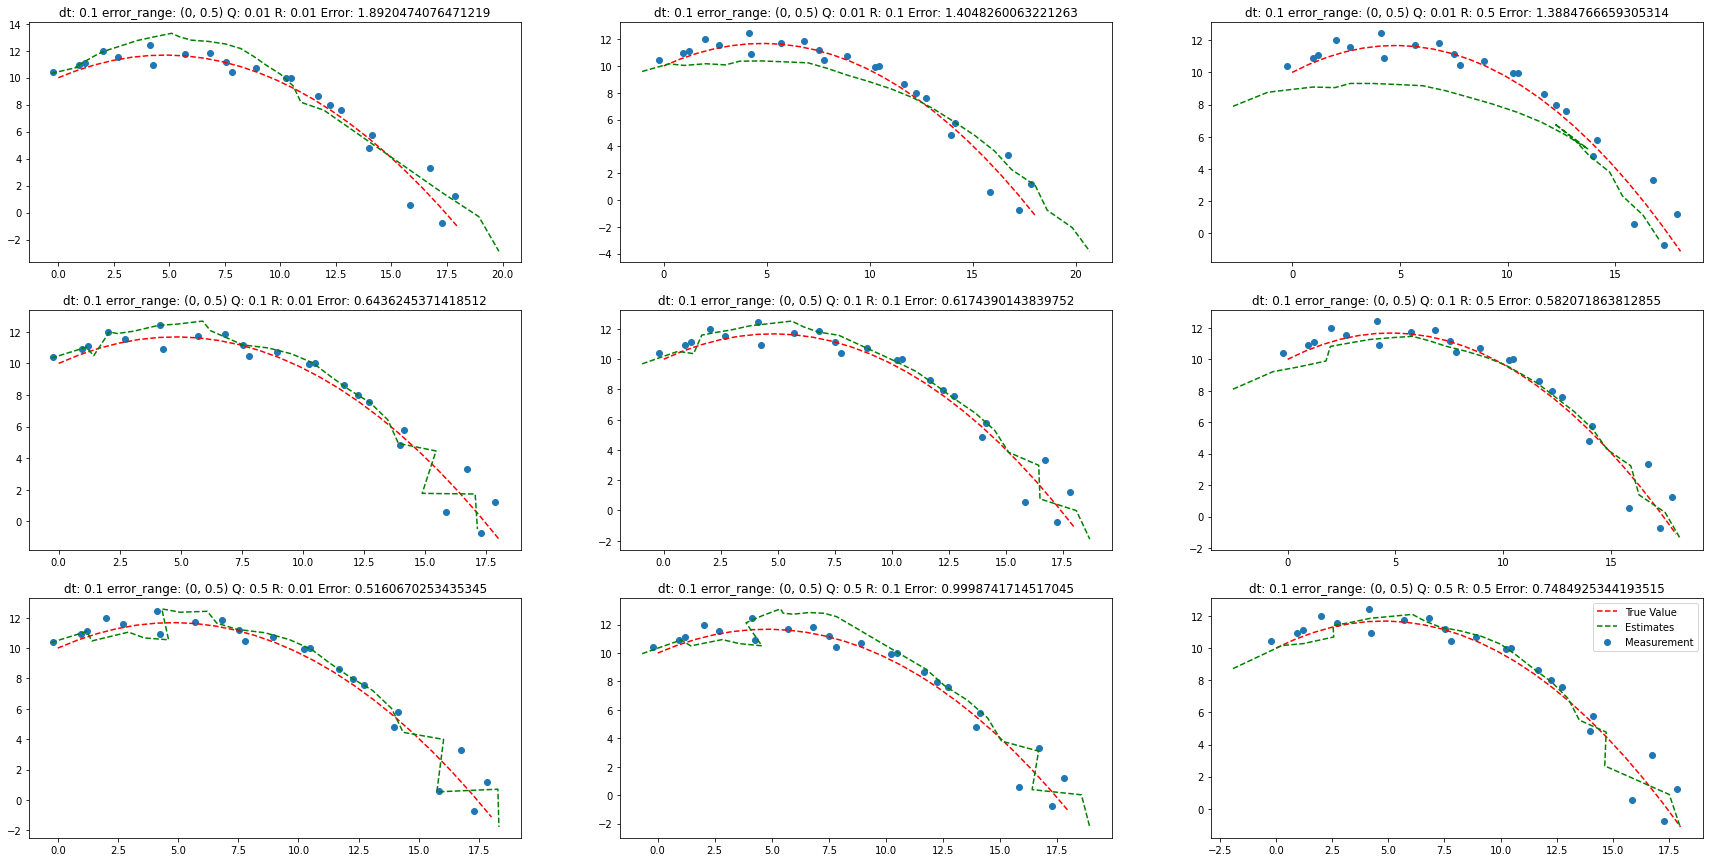

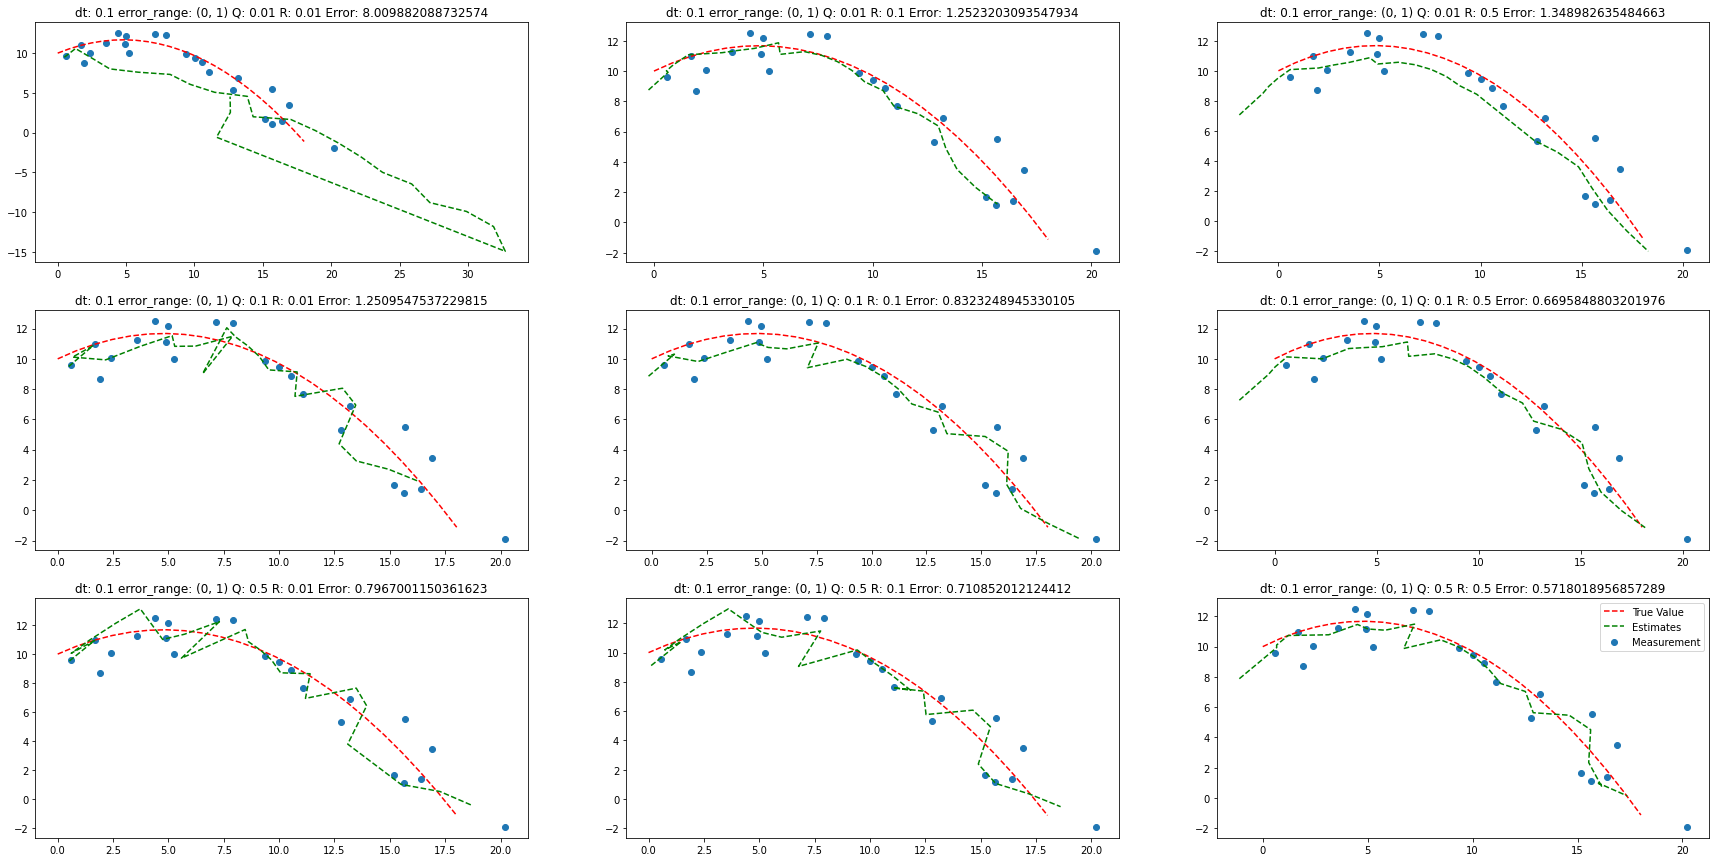

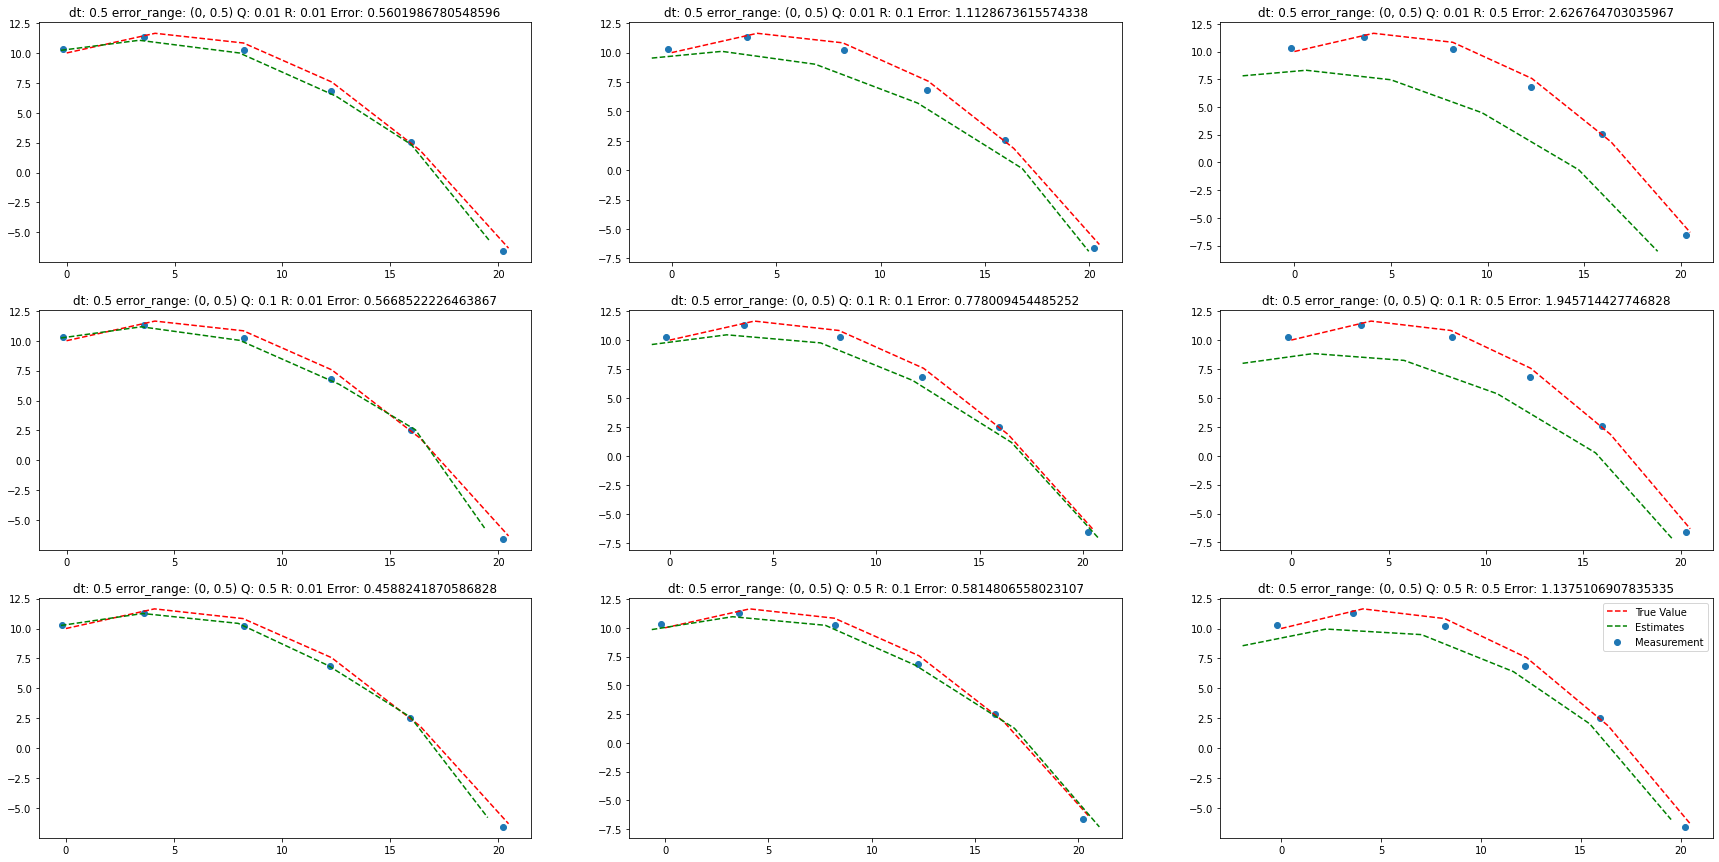

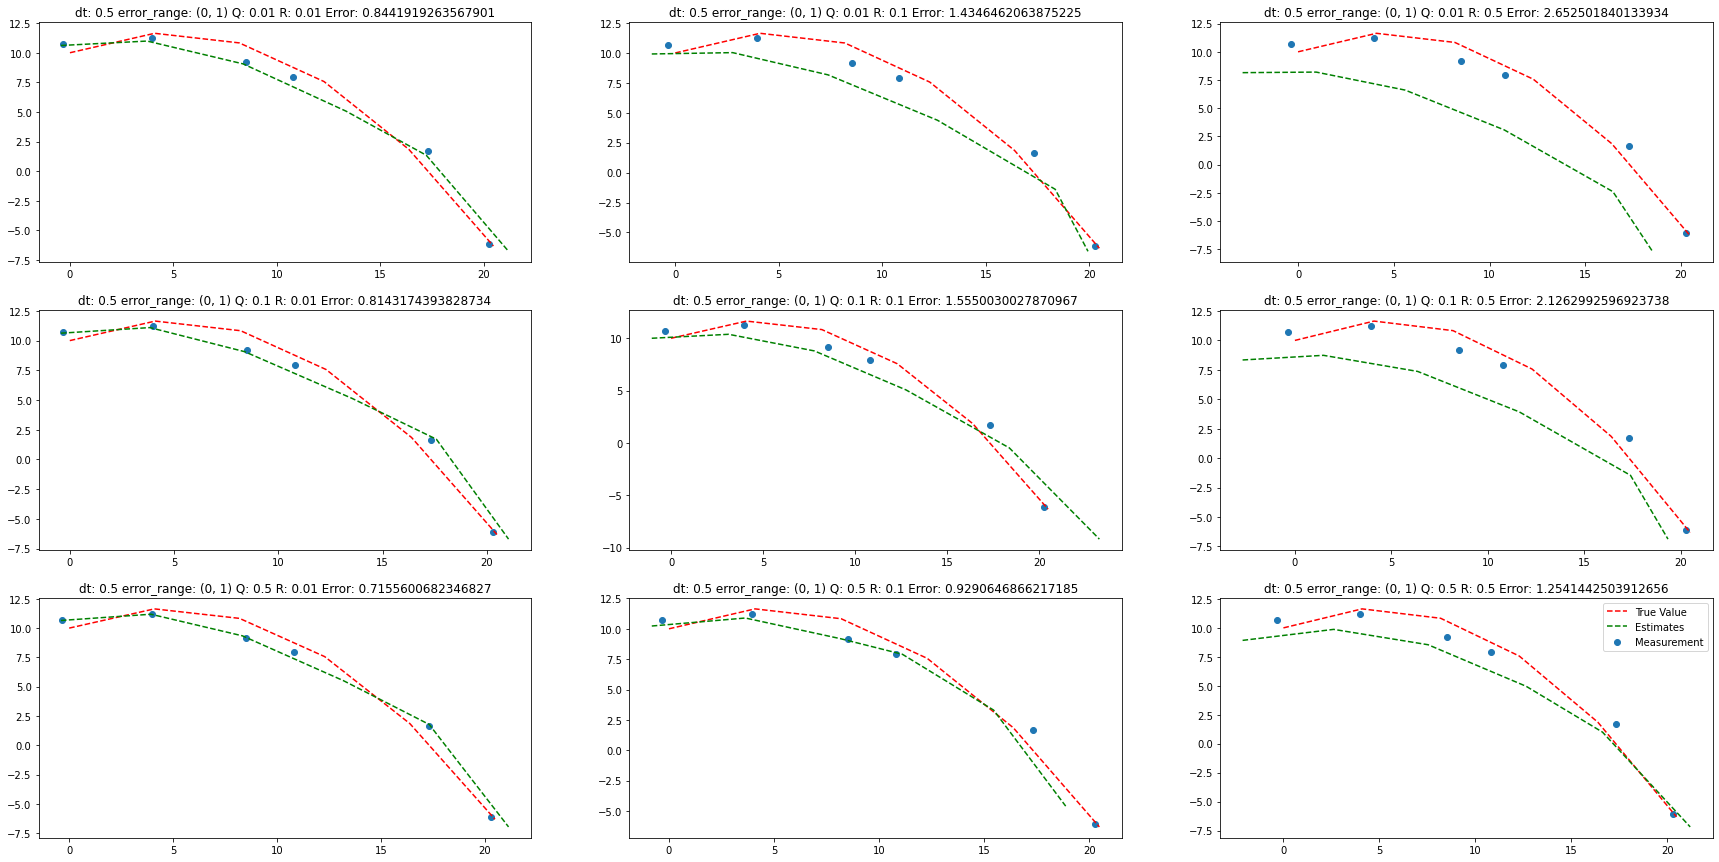

In [9]:
x = 0
y = 10
gravity = 9.81
angle = 35
velocity = 10
dts = [0.1, 0.5]
dropout=None
error_ranges=[(0, 0.5),(0, 1)]

Q_values = [0.01, 0.1, 0.5]
R_values = [0.01, 0.1, 0.5]

frame = pd.DataFrame(columns=["dt", "Error-range", "Factor Q", "Factor R", "Error"])

for k, d in enumerate(dts):
    for l, e in enumerate(error_ranges):
        fig, axs = plt.subplots(len(Q_values), len(R_values), figsize=(30,15))
        true_values, measurements, aligned_true_values = throw(launch_pos_x=x,
                                                              launch_pos_y=y,
                                                              launch_angle=angle,
                                                              launch_speed=velocity,
                                                              dt=d,
                                                              error_range_x=e,
                                                              error_range_y=e,
                                                              dropout=dropout,
                                                              gravity=gravity
                                                              )
        for i, q in enumerate(Q_values):
            for j, r in enumerate(R_values):
                title="dt: " + str(d) + " error_range: " + str(e) + " Q: " + str(q) + " R: " + str(r)
                error = do_a_run(values=(true_values, measurements, aligned_true_values),
                                          Q_value=q,
                                          R_value=r,
                                          dt=d,
                                          plot=axs[i, j],
                                          title=title)
                frame = frame.append(pd.Series([d, e, q, r, error], index=frame.columns), ignore_index=True)

        plt.legend()
        plt.show()


In [10]:
frame = frame.sort_values(by='Error', ascending=True)
print(frame.to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
 dt & Error-range &  Factor Q &  Factor R &    Error \\
\midrule
0.5 &    (0, 0.5) &      0.50 &      0.01 & 0.458824 \\
0.1 &    (0, 0.5) &      0.50 &      0.01 & 0.516067 \\
0.5 &    (0, 0.5) &      0.01 &      0.01 & 0.560199 \\
0.5 &    (0, 0.5) &      0.10 &      0.01 & 0.566852 \\
0.1 &      (0, 1) &      0.50 &      0.50 & 0.571802 \\
0.5 &    (0, 0.5) &      0.50 &      0.10 & 0.581481 \\
0.1 &    (0, 0.5) &      0.10 &      0.50 & 0.582072 \\
0.1 &    (0, 0.5) &      0.10 &      0.10 & 0.617439 \\
0.1 &    (0, 0.5) &      0.10 &      0.01 & 0.643625 \\
0.1 &      (0, 1) &      0.10 &      0.50 & 0.669585 \\
0.1 &      (0, 1) &      0.50 &      0.10 & 0.710852 \\
0.5 &      (0, 1) &      0.50 &      0.01 & 0.715560 \\
0.1 &    (0, 0.5) &      0.50 &      0.50 & 0.748493 \\
0.5 &    (0, 0.5) &      0.10 &      0.10 & 0.778009 \\
0.1 &      (0, 1) &      0.50 &      0.01 & 0.796700 \\
0.5 &      (0, 1) &      0.10 &      0.01 & 0.814317 \\
0.1 &  

In [11]:
qrframe = frame.drop(["Factor Q", "Factor R"], axis=1)
qrframe = qrframe[qrframe["Error-range"] == (0, 1)]
qrframe = qrframe.groupby(["dt"]).sum()
qrframe["Error-range"] = "mean: 0, scale: 1"
qframe = frame.drop(["Factor Q", "Factor R"], axis=1)
qframe = qframe[qframe["Error-range"] == (0, 0.5)]
qframe = qframe.groupby(["dt"]).sum()
qframe["Error-range"] = "mean: 0, scale: 0.5"
qrframe = qrframe.append(qframe)
qrframe = qrframe.sort_values(by='Error', ascending=True)
qrframe

,Error,Error-range
dt,,
0.1,8.792919,"mean: 0, scale: 0.5"
0.5,9.768222,"mean: 0, scale: 0.5"
0.5,12.325729,"mean: 0, scale: 1"
0.1,15.443404,"mean: 0, scale: 1"


## Comparing different Q and R matrices on dropout over 6 timesteps (10-15)

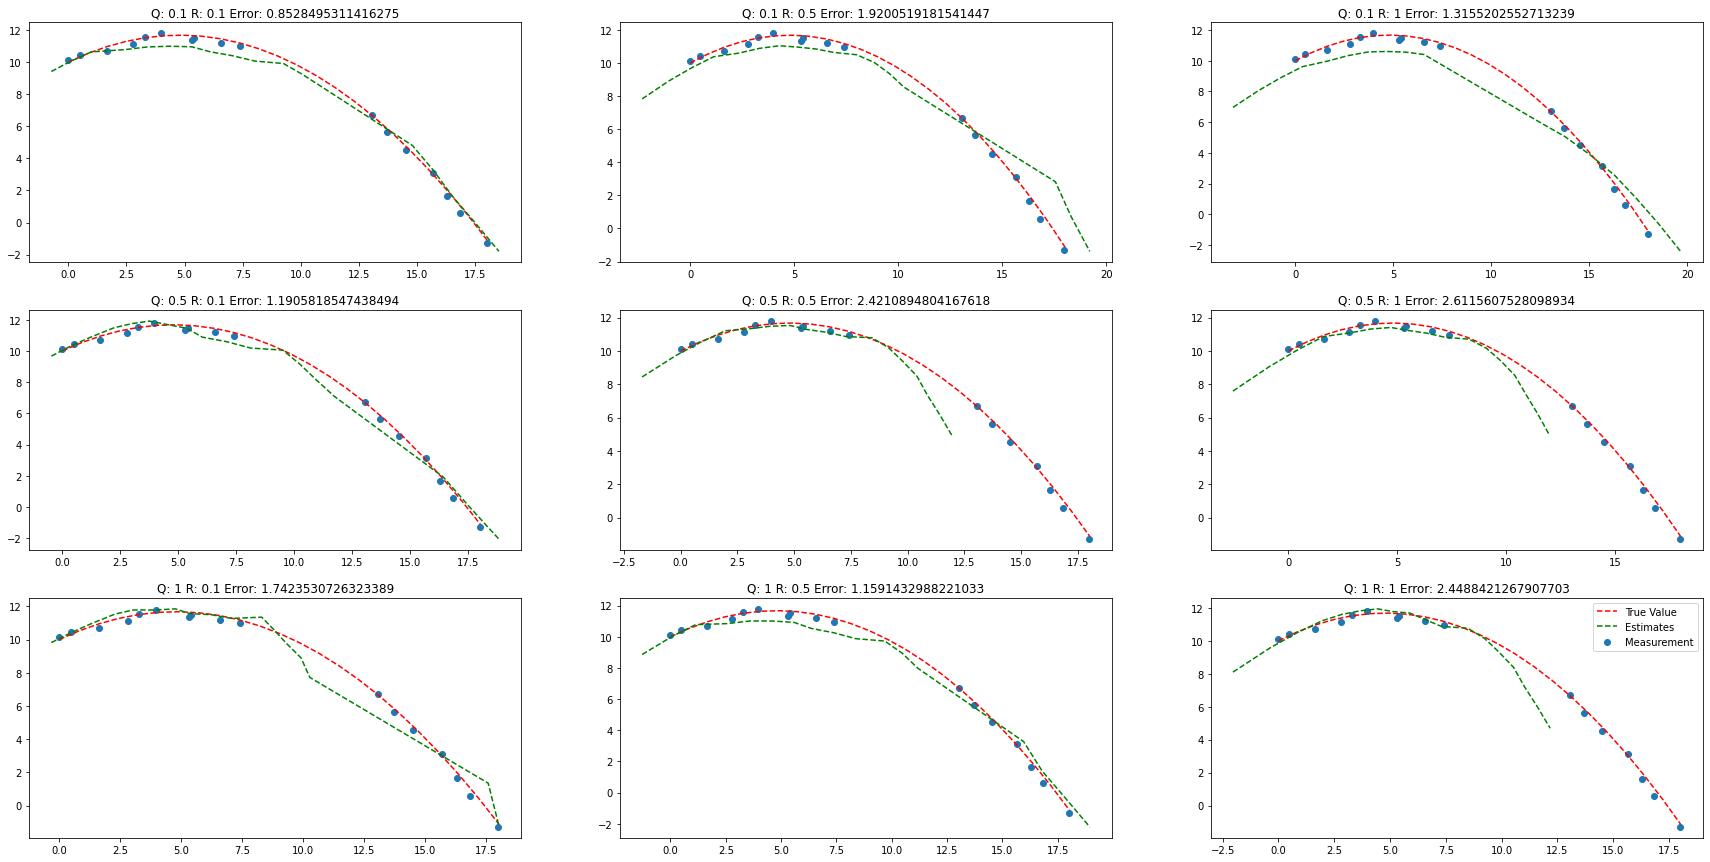

In [19]:
x = 0
y = 10
gravity = 9.81
angle = 35
velocity = 10
dt = 0.1
dropout=(10, 15)
error_range_x=(0, 0.2)
error_range_y=(0, 0.2)

Q_values = [0.1, 0.5, 1]
R_values = [0.1, 0.5, 1]
fig, axs = plt.subplots(len(Q_values), len(R_values), figsize=(30,15))

frame = pd.DataFrame(columns=["Factor Q", "Factor R", "Error", "Ratio Q/R"])
true_values, measurements, aligned_true_values = throw(launch_pos_x=x,
                                                      launch_pos_y=y,
                                                      launch_angle=angle,
                                                      launch_speed=velocity,
                                                      dt=dt,
                                                      error_range_x=error_range_x,
                                                      error_range_y=error_range_y,
                                                      dropout=dropout,
                                                      gravity=gravity
                                                      )
for i, q in enumerate(Q_values):
    for j, r in enumerate(R_values):
        title="Q: " + str(q) + " R: " + str(r)
        error = do_a_run(values=(true_values, measurements, aligned_true_values), dt=dt, Q_value=q, R_value=r, plot=axs[i, j], title=title)
        frame = frame.append(pd.Series([q, r, error, q/r], index=frame.columns), ignore_index=True)

plt.legend()
plt.show()

In [20]:
frame = frame.sort_values(by='Error', ascending=True)
print(frame.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 Factor Q &  Factor R &    Error &  Ratio Q/R \\
\midrule
      0.1 &       0.1 & 0.852850 &        1.0 \\
      1.0 &       0.5 & 1.159143 &        2.0 \\
      0.5 &       0.1 & 1.190582 &        5.0 \\
      0.1 &       1.0 & 1.315520 &        0.1 \\
      1.0 &       0.1 & 1.742353 &       10.0 \\
      0.1 &       0.5 & 1.920052 &        0.2 \\
      0.5 &       0.5 & 2.421089 &        1.0 \\
      1.0 &       1.0 & 2.448842 &        1.0 \\
      0.5 &       1.0 & 2.611561 &        0.5 \\
\bottomrule
\end{tabular}



## Comparing different throwing parameters (horizontal/ vertical startposition, angle, velocity)

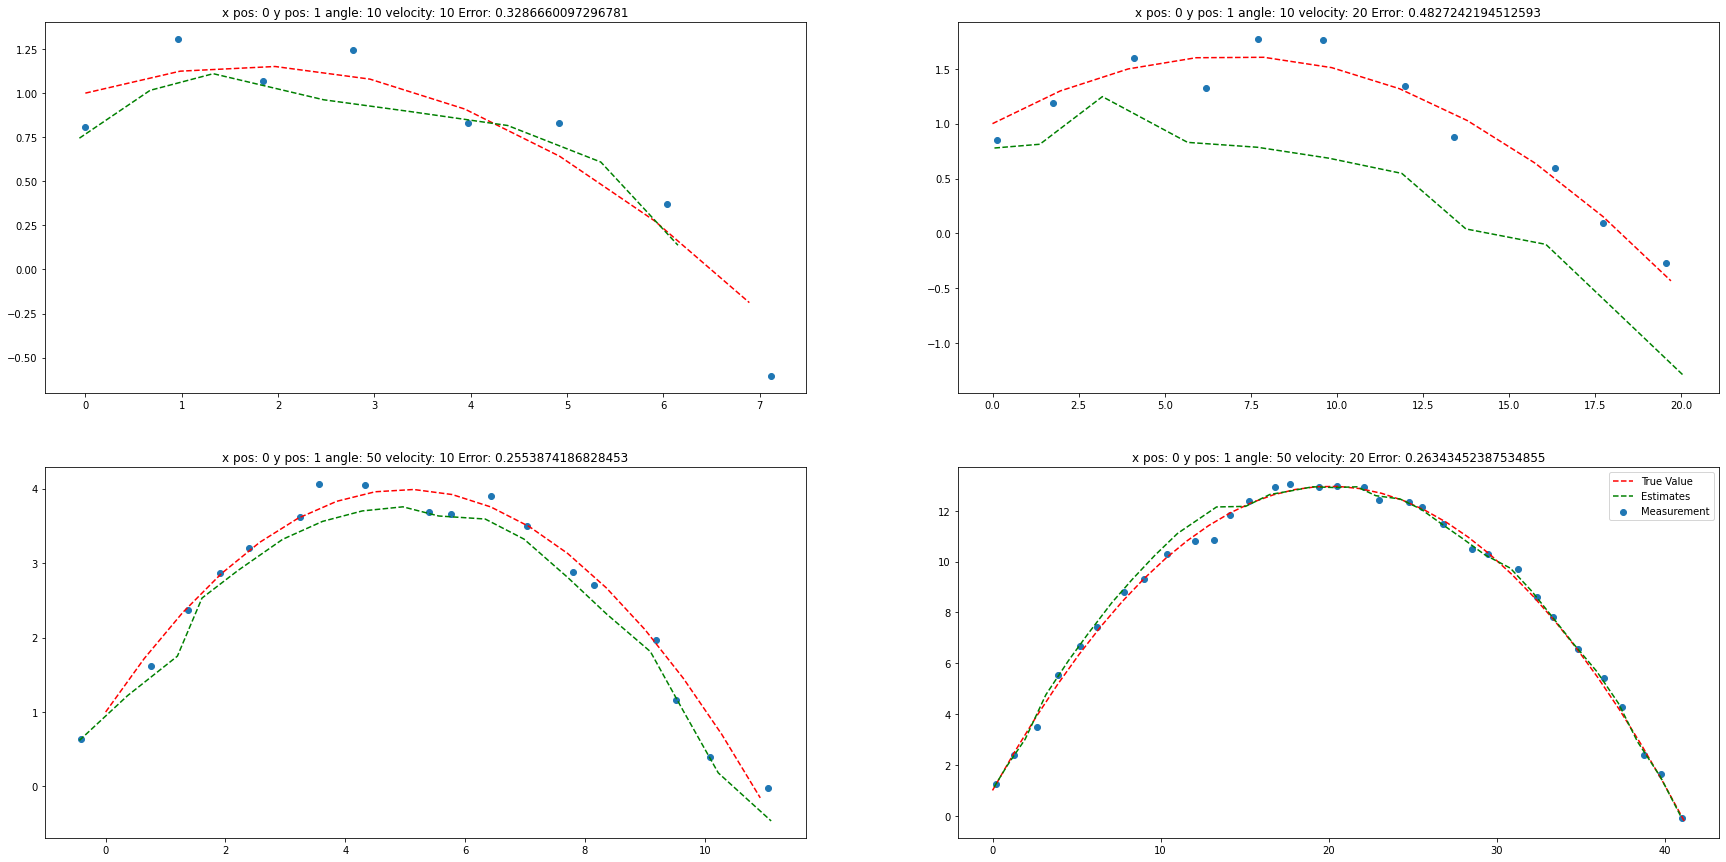

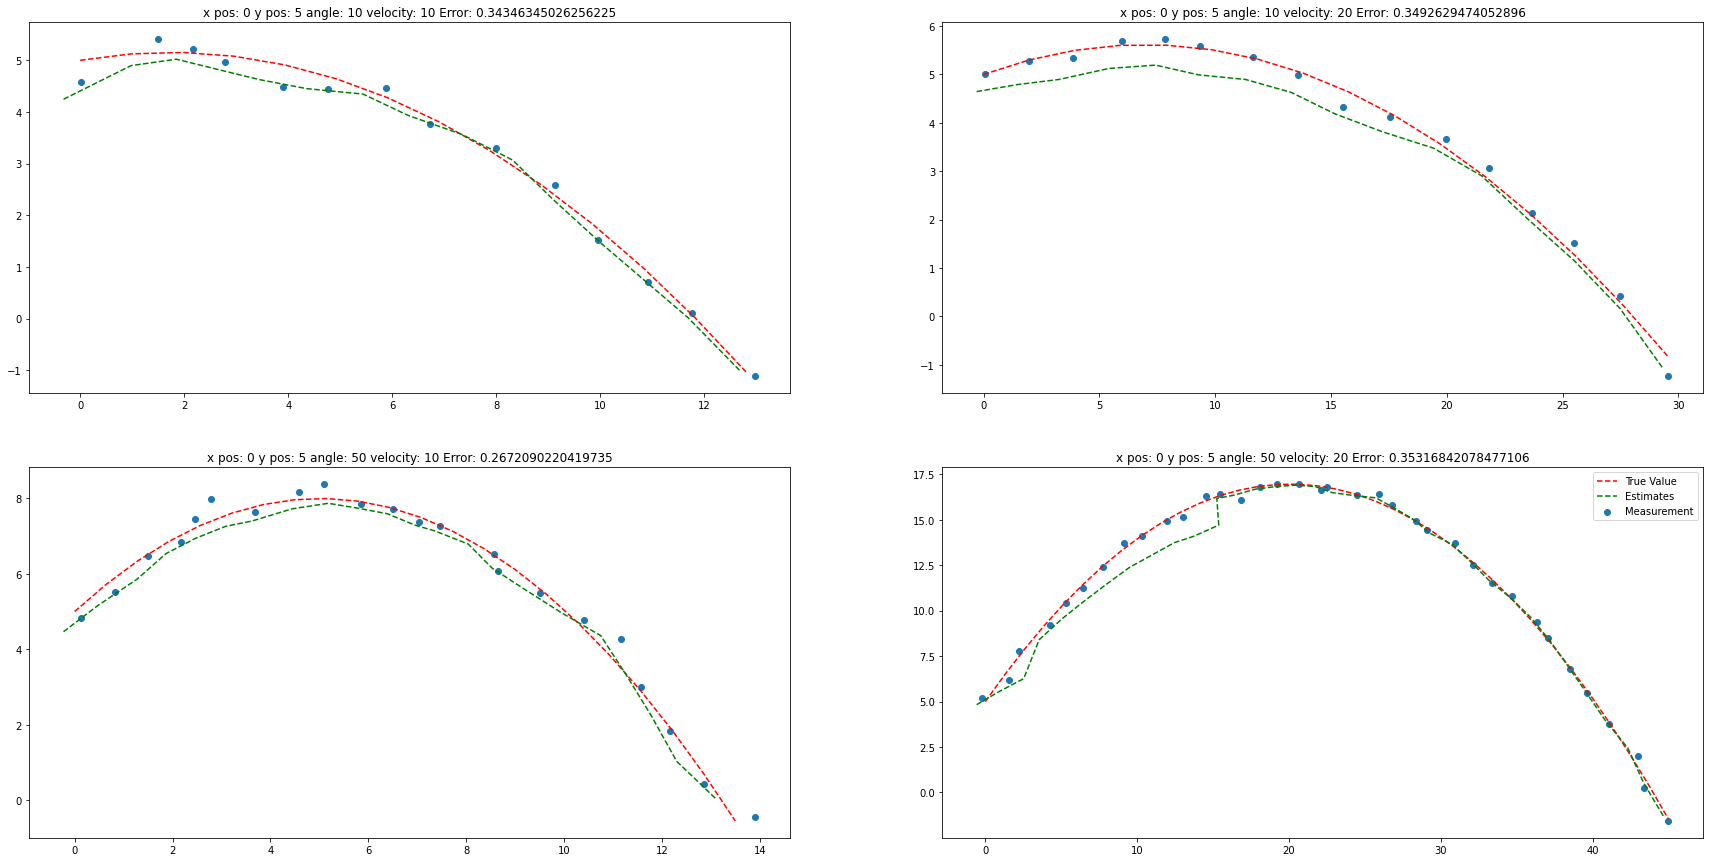

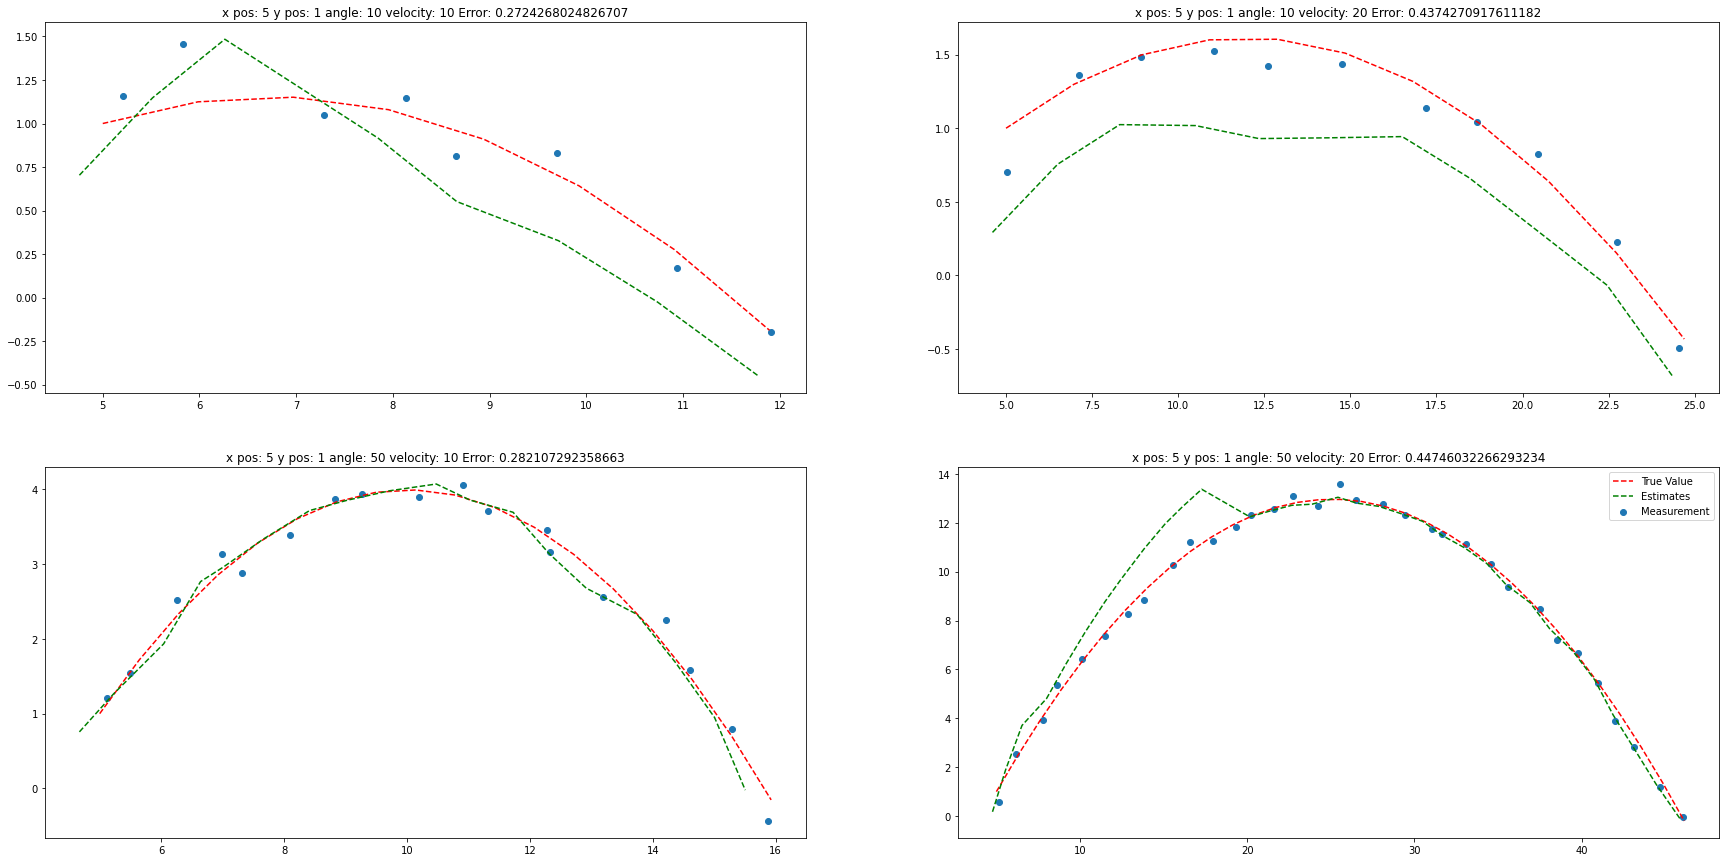

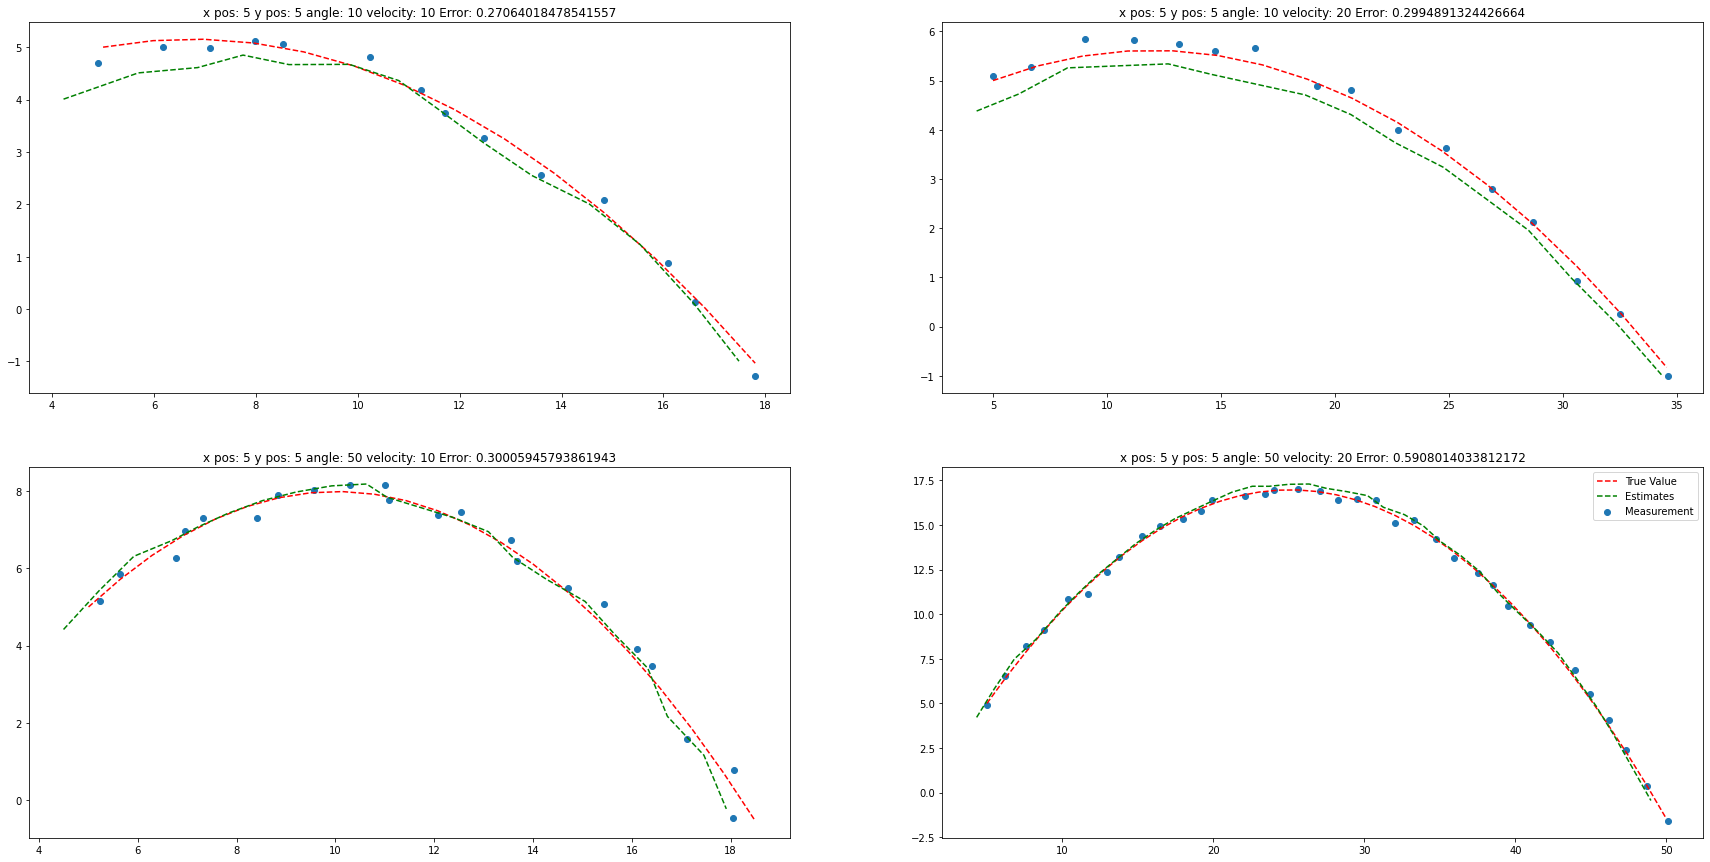

In [11]:
x = [0, 5]
y = [1, 5]
gravity = 9.81
angles = [10, 50]
velocities = [10, 20]
dt = 0.1
dropout=None
error_range_x=(0, 0.2)
error_range_y=(0, 0.2)

q = 0.1
r = 0.1

frame = pd.DataFrame(columns=["pos x", "pos y", "angle", "velocity", "Error"])

for k, d in enumerate(x):
    for l, e in enumerate(y):
        fig, axs = plt.subplots(len(angles), len(velocities), figsize=(30,15))
        for i, a in enumerate(angles):
            for j, v in enumerate(velocities):
                title="x pos: " + str(d) + " y pos: " + str(e) + " angle: " + str(a) + " velocity: " + str(v)
                error = do_a_run(x=d, y=e, angle=a, velocity=v, dt=dt, dropout=dropout, error_range_x=error_range_x,error_range_y=error_range_y, Q_value=q, R_value=r, plot=axs[i, j], title=title)
                frame = frame.append(pd.Series([k, e, a, v, error], index=frame.columns), ignore_index=True)

        plt.legend()
        plt.show()

In [12]:
frame = frame.sort_values(by='Error', ascending=True)
print(frame.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 pos x &  pos y &  angle &  velocity &    Error \\
\midrule
   0.0 &    1.0 &   50.0 &      10.0 & 0.255387 \\
   0.0 &    1.0 &   50.0 &      20.0 & 0.263435 \\
   0.0 &    5.0 &   50.0 &      10.0 & 0.267209 \\
   1.0 &    5.0 &   10.0 &      10.0 & 0.270640 \\
   1.0 &    1.0 &   10.0 &      10.0 & 0.272427 \\
   1.0 &    1.0 &   50.0 &      10.0 & 0.282107 \\
   1.0 &    5.0 &   10.0 &      20.0 & 0.299489 \\
   1.0 &    5.0 &   50.0 &      10.0 & 0.300059 \\
   0.0 &    1.0 &   10.0 &      10.0 & 0.328666 \\
   0.0 &    5.0 &   10.0 &      10.0 & 0.343463 \\
   0.0 &    5.0 &   10.0 &      20.0 & 0.349263 \\
   0.0 &    5.0 &   50.0 &      20.0 & 0.353168 \\
   1.0 &    1.0 &   10.0 &      20.0 & 0.437427 \\
   1.0 &    1.0 &   50.0 &      20.0 & 0.447460 \\
   0.0 &    1.0 &   10.0 &      20.0 & 0.482724 \\
   1.0 &    5.0 &   50.0 &      20.0 & 0.590801 \\
\bottomrule
\end{tabular}



## Comparing different state value (q_t) initializations

Different (y axis = height, x axis = range)


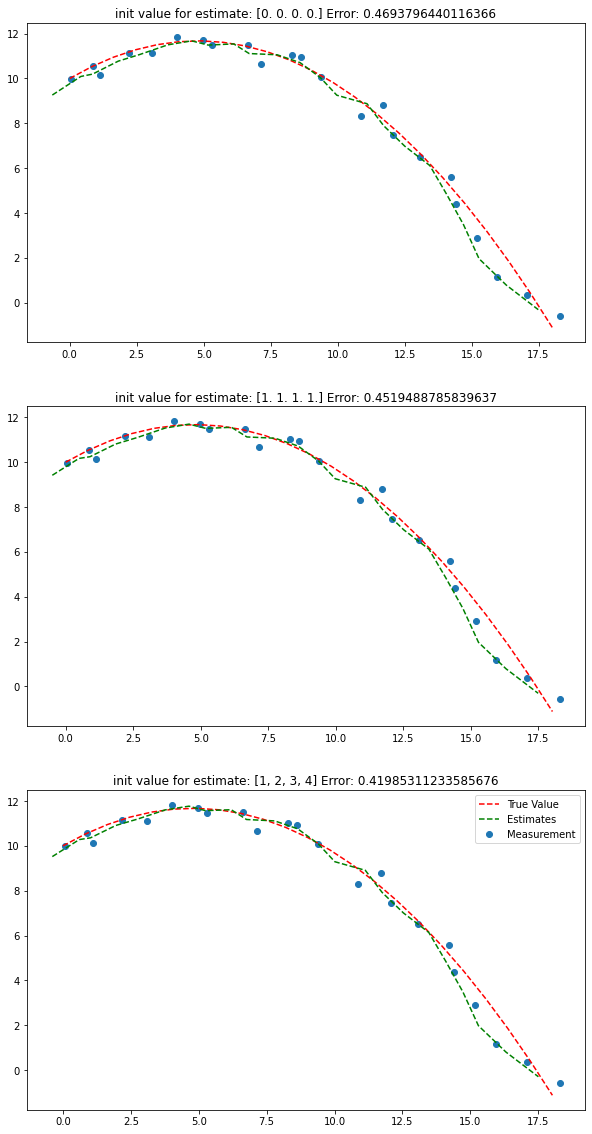

In [21]:
x = 0
y = 10
gravity = 9.81
angle = 35
velocities = 10
dt = 0.1
dropout = None
error_range_x = (0, 0.3)
error_range_y = (0, 0.5)

m_init_vals = [np.zeros(4), np.ones(4), [1, 2, 3, 4]]

q = 0.1
r = 0.1

print("Different (y axis = height, x axis = range)")
fig, axs = plt.subplots(len(m_init_vals), figsize=(10, 20))
frame = pd.DataFrame(columns=["Init Values", "Error"])

true_values, measurements, aligned_true_values = throw(launch_pos_x=x,
                                                      launch_pos_y=y,
                                                      launch_angle=angle,
                                                      launch_speed=velocity,
                                                      dt=dt,
                                                      error_range_x=error_range_x,
                                                      error_range_y=error_range_y,
                                                      dropout=dropout,
                                                      gravity=gravity
                                                      )

for j, v in enumerate(m_init_vals):
    title = "init value for estimate: " + str(v)
    error = do_a_run(values=(true_values, measurements, aligned_true_values), m_init=v, dt=dt, Q_value=q, R_value=r, plot=axs[j], title=title)
    frame = frame.append(pd.Series([v, error], index=frame.columns), ignore_index=True)

plt.legend()
plt.show()

In [22]:
print(frame.to_latex(index=False))

\begin{tabular}{lr}
\toprule
         Init Values &    Error \\
\midrule
[0.0, 0.0, 0.0, 0.0] & 0.469380 \\
[1.0, 1.0, 1.0, 1.0] & 0.451949 \\
        [1, 2, 3, 4] & 0.419853 \\
\bottomrule
\end{tabular}

